In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

dash_fundamentus = pd.read_excel('estquant_fundamentus_gabriel.xlsx')
dash_fundamentus.columns

Index(['Cod', 'Ebit 1t', 'Ebit 2t', 'Ebit 2-1t', 'Ebit 1t Ltm', 'Ebit 2t Ltm',
       'Ebit 2-1t Ltm', 'Ebitda 1t', 'Ebitda 2t', 'Ebitda 2-1t',
       'Ebitda 1t Ltm', 'Ebitda 2t Ltm', 'Ebitda 2-1t Ltm', 'Cfo 1t', 'Cfo 2t',
       'Cfo 2-1t', 'Cfo 1t Ltm', 'Cfo 2t Ltm', 'Cfo 2-1t Ltm', 'Perf_pos2t',
       'Var_Ibov', 'Var_Small'],
      dtype='object')

In [2]:
dash_fundamentus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cod              274 non-null    object 
 1   Ebit 1t          274 non-null    float64
 2   Ebit 2t          274 non-null    float64
 3   Ebit 2-1t        274 non-null    float64
 4   Ebit 1t Ltm      274 non-null    float64
 5   Ebit 2t Ltm      274 non-null    float64
 6   Ebit 2-1t Ltm    274 non-null    float64
 7   Ebitda 1t        274 non-null    float64
 8   Ebitda 2t        274 non-null    float64
 9   Ebitda 2-1t      274 non-null    float64
 10  Ebitda 1t Ltm    274 non-null    float64
 11  Ebitda 2t Ltm    274 non-null    float64
 12  Ebitda 2-1t Ltm  274 non-null    float64
 13  Cfo 1t           274 non-null    float64
 14  Cfo 2t           274 non-null    float64
 15  Cfo 2-1t         274 non-null    float64
 16  Cfo 1t Ltm       274 non-null    float64
 17  Cfo 2t Ltm      

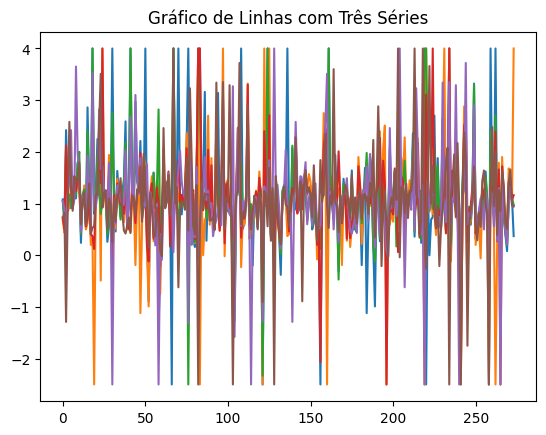

In [3]:
for i in range(1, len(dash_fundamentus.columns)-3):
    dash_fundamentus.iloc[:, i] = dash_fundamentus.iloc[:, i].clip(lower=-2.5, upper=4)    

# Criar o gráfico
plt.plot(dash_fundamentus['Ebit 1t'], label='Série 1')
plt.plot(dash_fundamentus['Ebit 2t'], label='Série 2')
plt.plot(dash_fundamentus['Ebitda 1t'], label='Série 3')
plt.plot(dash_fundamentus['Ebitda 2t'], label='Série 4')
plt.plot(dash_fundamentus['Cfo 1t'], label='Série 5')
plt.plot(dash_fundamentus['Cfo 2t'], label='Série 6')
plt.title('Gráfico de Linhas com Três Séries')
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


features = np.array(dash_fundamentus[[
    # 'Ebit 1t', 'Ebit 2t', 'Ebit 2-1t', 'Ebit 1t Ltm', 'Ebit 2t Ltm',
    # 'Ebit 2-1t Ltm', 'Ebitda 1t', 'Ebitda 2t', 'Ebitda 2-1t',
    # 'Ebitda 1t Ltm', 'Ebitda 2t Ltm', 'Ebitda 2-1t Ltm', 'Cfo 1t', 'Cfo 2t',
    # 'Cfo 2-1t', 'Cfo 1t Ltm', 'Cfo 2t Ltm', 'Cfo 2-1t Ltm'

    'Ebit 2-1t Ltm',
    'Ebitda 2-1t Ltm',
    'Cfo 2-1t Ltm'
        
    ]])

scaler = MinMaxScaler()
features_minmax = scaler.fit_transform(features)

scaler2 = StandardScaler()
features_normalizados = scaler2.fit_transform(features)

In [6]:
# definicao do target
def determine_quartile(value, quartil1, quartil2, quartil3):
    if value <= quartil1:
        return 1
    elif value <= quartil2:
        return 2
    elif value <= quartil3:
        return 3
    else:
        return 4

def input_label_classes(df):
    nome_acoes = np.array(df['Cod'])
    retorno_acoes = np.array(df['Perf_pos2t'])
    rank = (retorno_acoes - np.min(retorno_acoes)) / (np.max(retorno_acoes) - np.min(retorno_acoes))

    Q1 = np.percentile(rank, 25)
    Q2 = np.percentile(rank, 50) 
    Q3 = np.percentile(rank, 75)
    print(f'Q1: {Q1}, Q2: {Q2}, Q3: {Q3}')

    quartile_labels = np.array([determine_quartile(x, Q1, Q2, Q3) for x in rank])
    target= np.column_stack((nome_acoes, retorno_acoes, quartile_labels))
    return target

target1 = input_label_classes(dash_fundamentus.iloc[0:137,:])
target2 =  input_label_classes(dash_fundamentus.iloc[137:,:])
target = np.vstack((target1, target2))


Q1: 0.4789557805007992, Q2: 0.5552172920313571, Q3: 0.6233351092168354
Q1: 0.28188219514921203, Q2: 0.3822510338661004, Q3: 0.48183748742595284


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# transformando em one hot encoder
encoder = OneHotEncoder(sparse=False)
label = target[:, -1].reshape(-1, 1)
labels_one_hot = encoder.fit_transform(label)

# primeiros 10 labels)                                       
X = features
y = labels_one_hot

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1312)

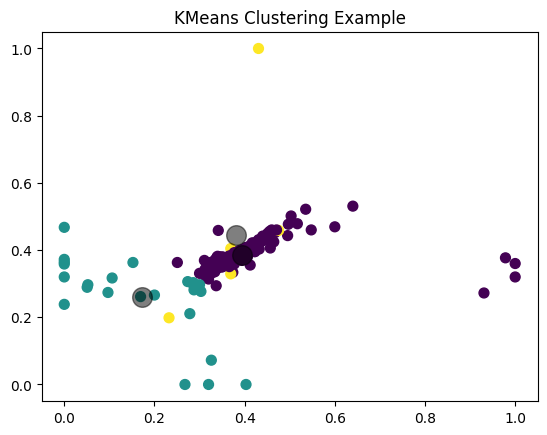

In [25]:
# algoritmo de clusterizacao
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# # Visualizar os resultados
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("KMeans Clustering Example")
plt.show()

In [9]:
# analise da clusterizacao
# preciso verificar os labels dos respectivos grupos
y_kmeans.shape
target.shape
array_cmeans = np.column_stack([target, y_kmeans])

print(np.sum(array_cmeans[array_cmeans[:, -1] == 0, 1]))
print(np.mean(array_cmeans[array_cmeans[:, -1] == 0, 1]))

for i in range(4):
    print(f'\nRetorno do cluster {i}: {np.sum(array_cmeans[array_cmeans[:, -1] == i, 1])}')
    print(f'Retorno do cluster {i}: {np.mean(array_cmeans[array_cmeans[:, -1] == i, 1])}')    
    print(f'Retorno do cluster {i}: {np.count_nonzero(array_cmeans[array_cmeans[:, -1] == i, 1])}')        

0.13540000000000751
0.0005641666666666979

Retorno do cluster 0: 0.13540000000000751
Retorno do cluster 0: 0.0005641666666666979
Retorno do cluster 0: 240

Retorno do cluster 1: -0.0754
Retorno do cluster 1: -0.009425
Retorno do cluster 1: 8

Retorno do cluster 2: 0.5622
Retorno do cluster 2: 0.14055
Retorno do cluster 2: 4

Retorno do cluster 3: -0.20590000000000008
Retorno do cluster 3: -0.009359090909090912
Retorno do cluster 3: 22


Epoch 1/4000
1/1 [==============================] - 0s 279ms/step - loss: 1.3894 - accuracy: 0.2557 - val_loss: 1.3830 - val_accuracy: 0.2727
Epoch 2/4000
1/1 [==============================] - 0s 11ms/step - loss: 1.3886 - accuracy: 0.2557 - val_loss: 1.3834 - val_accuracy: 0.2727
Epoch 3/4000
1/1 [==============================] - 0s 11ms/step - loss: 1.3879 - accuracy: 0.2557 - val_loss: 1.3838 - val_accuracy: 0.2727
Epoch 4/4000
1/1 [==============================] - 0s 11ms/step - loss: 1.3874 - accuracy: 0.2557 - val_loss: 1.3844 - val_accuracy: 0.2727
Epoch 5/4000
1/1 [==============================] - 0s 11ms/step - loss: 1.3869 - accuracy: 0.2648 - val_loss: 1.3848 - val_accuracy: 0.2000
Epoch 6/4000
1/1 [==============================] - 0s 11ms/step - loss: 1.3865 - accuracy: 0.2831 - val_loss: 1.3852 - val_accuracy: 0.2364
Epoch 7/4000
1/1 [==============================] - 0s 11ms/step - loss: 1.3862 - accuracy: 0.2557 - val_loss: 1.3857 - val_accuracy: 0.2182
Epoch 8/4000

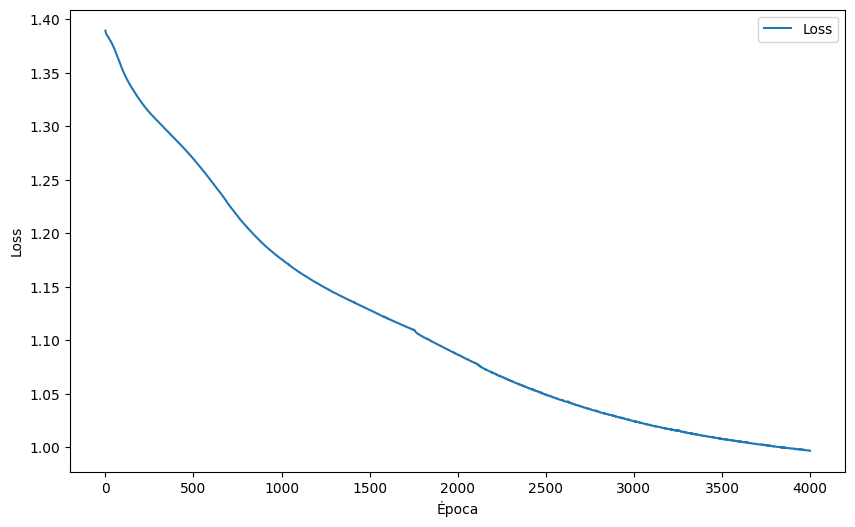

In [21]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir a arquitetura da rede neural
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Camada de entrada com o mesmo número de features
    keras.layers.Dense(64, activation='relu'),      # Camada oculta com 128 neurônios e função de ativação ReLU
    keras.layers.Dense(32, activation='relu'),       # Outra camada oculta com 64 neurônios e função de ativação ReLU
    keras.layers.Dense(y_train.shape[1], activation='softmax')  # Camada de saída com o número de neurônios igual ao número de classes
])

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=4000, batch_size=X_train.shape[0], validation_data=(X_test, y_test))

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%")

# Plotar o histórico de perda
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()



2/2 [==============================] - 0s 1ms/step


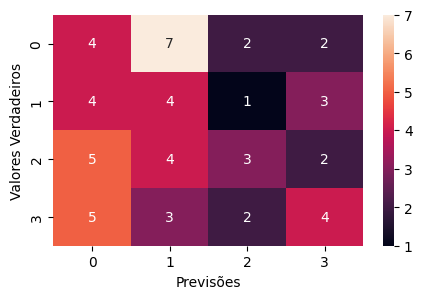

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Construir a matriz de confusão
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Previsões')
plt.ylabel('Valores Verdadeiros')
plt.show()


In [23]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Acurácia: {accuracy:.2f}")
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
print(f"Precisão: {precision:.2f}")
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')
print(f"F1 Score: {f1:.2f}")

Acurácia: 0.27
Precisão: 0.30
F1 Score: 0.28


In [13]:
# acima e abaixo da media
# 04 quartis
median = np.median(features, axis=0)
classified = (features > median).astype(int)
classified

array([[1, 1, 1],
       [0, 0, 0],
       [1, 1, 0],
       [1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 0],
       [1, 1, 1],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1],
       [0, 1, 1],
       [0, 0, 0],
       [1, 1, 1],
       [0, 1, 1],
       [0, 0, 0],
       [1, 1, 0],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 1, 1],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 1],
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0,

In [14]:
performance = target[:, 1]




for i in range(classified.shape[1]):
    print(f'\ncoluna: {i}')
    mask = (classified[:, i] == 1)
    resultado = performance[mask]
    print('valores > mediana')
    print(np.median(resultado))
    print(np.mean(resultado))
    print(np.sum(resultado))    
    
    print('\nvalores < mediana')
    mask = (classified[:, i] == 0)
    resultado = performance[mask]
    print(np.median(resultado))
    print(np.mean(resultado))
    print(np.sum(resultado))    
    print('#### #### ####')


coluna: 0
valores > mediana
0.022
0.014431578947368413
1.9193999999999989

valores < mediana
-0.0236
-0.010660283687943263
-1.5031
#### #### ####

coluna: 1
valores > mediana
0.0165
0.019817037037037032
2.6752999999999996

valores < mediana
-0.0278
-0.016251798561151075
-2.2589999999999995
#### #### ####

coluna: 2
valores > mediana
0.0184
0.024418604651162794
3.1500000000000004

valores < mediana
-0.0249
-0.018853103448275864
-2.7337000000000002
#### #### ####


In [52]:
# definicao do target
def determine_quartile(value, quartil1, quartil2, quartil3):
    if value <= quartil1:
        return 1
    elif value <= quartil2:
        return 2
    elif value <= quartil3:
        return 3
    else:
        return 4

def input_label_classes(df, coluna):
    nome_acoes = np.array(df['Cod'])
    retorno_acoes1 = np.array(df['Perf_pos2t']) 
    retorno_acoes = np.array(df[coluna])
    rank = (retorno_acoes - np.min(retorno_acoes)) / (np.max(retorno_acoes) - np.min(retorno_acoes))

    Q1 = np.percentile(rank, 25)
    Q2 = np.percentile(rank, 50) 
    Q3 = np.percentile(rank, 75)
    print(f'Q1: {Q1}, Q2: {Q2}, Q3: {Q3}')

    quartile_labels = np.array([determine_quartile(x, Q1, Q2, Q3) for x in rank])
    target= np.column_stack((nome_acoes, retorno_acoes1, quartile_labels))
    return target

separacao_quartis = input_label_classes(dash_fundamentus.iloc[:,:], 'Cfo 2-1t Ltm')

Q1: 0.3569230769230769, Q2: 0.37692307692307697, Q3: 0.39384615384615385


In [54]:
separacao_quartis = input_label_classes(dash_fundamentus.iloc[:,:], 'Cfo 2-1t Ltm')
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==1][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==2][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==3][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==4][:, 1]))

Q1: 0.3569230769230769, Q2: 0.37692307692307697, Q3: 0.39384615384615385
-0.02560000000000002
-0.012379729729729737
0.024764062499999996
0.024078461538461556


In [58]:
separacao_quartis = input_label_classes(dash_fundamentus.iloc[:,:], 'Ebitda 2-1t Ltm')
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==1][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==2][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==3][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==4][:, 1]))

Q1: 0.6238003838771593, Q2: 0.6928982725527831, Q3: 0.7288867562380038
-0.004009859154929574
0.009843283582089555
0.007549253731343284
-0.006728985507246368


In [56]:
separacao_quartis = input_label_classes(dash_fundamentus.iloc[:,:], 'Ebit 2-1t Ltm')
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==1][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==2][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==3][:, 1]))
print(np.mean(separacao_quartis[separacao_quartis[:, -1]==4][:, 1]))

Q1: 0.35423076923076924, Q2: 0.37692307692307697, Q3: 0.39692307692307693
-0.021307246376811598
-0.0004569444444444342
-0.020784615384615384
0.048094117647058815


In [57]:
separacao_quartis = input_label_classes(dash_fundamentus.iloc[:,:], 'Cfo 2-1t Ltm')
a = separacao_quartis[separacao_quartis[:, -1]==4]
print(np.mean(a[:, 1]))
print(a)

Q1: 0.3569230769230769, Q2: 0.37692307692307697, Q3: 0.39384615384615385
0.024078461538461556
[['VALE3' 0.0368 4]
 ['RENT3' -0.1523 4]
 ['ITSA4' -0.0416 4]
 ['WEGE3' -0.1215 4]
 ['BPAC11' -0.0536 4]
 ['RDOR3' -0.2206 4]
 ['VIVT3' 0.088 4]
 ['ENEV3' -0.0978 4]
 ['HAPV3' -0.1901 4]
 ['CCRO3' -0.0404 4]
 ['CMIN3' 0.1429 4]
 ['CYRE3' -0.213 4]
 ['CIEL3' -0.0954 4]
 ['ABCB4' 0.0255 4]
 ['CLSA3' -0.1051 4]
 ['ECOR3' -0.0608 4]
 ['ESPA3' -0.0946 4]
 ['HBSA3' 0.0306 4]
 ['JHSF3' -0.1578 4]
 ['LAVV3' -0.1732 4]
 ['LOGN3' -0.1218 4]
 ['POMO4' -0.0359 4]
 ['LEVE3' -0.1744 4]
 ['BEEF3' -0.2479 4]
 ['MRVE3' -0.2988 4]
 ['ORVR3' 0.0308 4]
 ['PLPL3' -0.292 4]
 ['LJQQ3' -0.3836 4]
 ['TGMA3' -0.0298 4]
 ['TEND3' -0.1727 4]
 ['TRIS3' -0.2477 4]
 ['VALE3' 0.1494 4]
 ['ELET3' 0.1254 4]
 ['RENT3' 0.0926 4]
 ['ITSA4' 0.1272 4]
 ['BPAC11' 0.1044 4]
 ['UGPA3' 0.2937 4]
 ['VBBR3' 0.1979 4]
 ['ENEV3' 0.1125 4]
 ['EMBR3' 0.3074 4]
 ['TIMS3' 0.1406 4]
 ['ASAI3' 0.0707 4]
 ['CCRO3' 0.1019 4]
 ['CSNA3' 0.528 4]
 ['

In [49]:
dash_fundamentus['Perf_pos2t']

0      0.0368
1      0.1911
2     -0.0266
3     -0.0779
4     -0.1523
        ...  
269    0.2965
270    0.2620
271    0.1140
272    0.1996
273   -0.0213
Name: Perf_pos2t, Length: 274, dtype: float64